# Utilizar a rede Siamesa para classificação

In [1]:
import numpy as np
import os
import random
import tensorflow as tf
import time
import shutil


from PIL import Image

2021-09-11 16:40:59.556139: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
caminho_base = os.path.join(os.path.expanduser('~'), 'gdrive_ajna')
caminho_pares = os.path.join(caminho_base, 'pares_transito_01Jan_10Ago')
caminho_pares_resize = os.path.join(caminho_base, 'pares_transito_resized')

SIZE = (224, 224)

In [3]:
# Procura diretórios com mais de uma dupla para inspeção visual

# lista_diretorios = os.listdir(caminho_pares)
for pasta in lista_diretorios:
    caminho = os.path.join(caminho_pares, pasta)
    lista_arquivos = os.listdir(caminho)
    if len(lista_arquivos) !=2:
        print(pasta)

NameError: name 'lista_diretorios' is not defined

In [4]:
# Copia todas as imagens, já realizando o resize necessário

#lista_diretorios = os.listdir(caminho_pares)
# shutil.rmtree(caminho_pares_resize)
os.mkdir(caminho_pares_resize)
for pasta in lista_diretorios:
    caminho = os.path.join(caminho_pares, pasta)
    caminho_resize = os.path.join(caminho_pares_resize, pasta)
    os.mkdir(caminho_resize)
    lista_arquivos = os.listdir(caminho)
    for arquivo in lista_arquivos:
        pil_img = Image.open(os.path.join(caminho, arquivo))
        pil_img = pil_img.resize(SIZE, Image.LANCZOS)
        pil_img.save(os.path.join(caminho_resize, arquivo))


FileExistsError: [Errno 17] File exists: '/home/ivan/gdrive_ajna/pares_transito_resized'

# Carrega imagens

In [5]:
# Carrega os pares em uma lista List[(Pil.Image, Pil.Image)]
lista_pares = []
lista_diretorios = os.listdir(caminho_pares_resize)
for pasta in lista_diretorios:
    caminho_resize = os.path.join(caminho_pares_resize, pasta)
    #print(caminho_resize)
    lista_arquivos = os.listdir(caminho_resize)
    if len(lista_arquivos) > 1:
        try:
            pil_img0 = Image.open(os.path.join(caminho_resize, lista_arquivos[0]))
            pil_img1 = Image.open(os.path.join(caminho_resize, lista_arquivos[1]))
            lista_pares.append((pil_img0, pil_img1))
        except OSError:
            pass   


In [6]:
print(len(lista_pares))

506


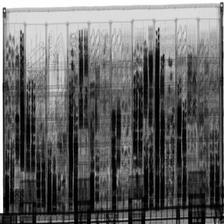

In [7]:
lista_pares[0][0]

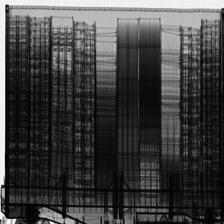

In [8]:
lista_pares[0][1]

# Models

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, \
    BatchNormalization, concatenate, Dense, Dropout, Flatten, Input, MaxPooling2D

nuclear_model = tf.keras.applications.EfficientNetB0(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    include_top=False,
    input_shape=(*SIZE, 3))
# nuclear_model.trainable = False
nuclear_model.summary()

2021-09-11 16:45:07.805696: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-09-11 16:45:07.947636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-11 16:45:07.948028: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 6 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2021-09-11 16:45:07.948059: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-09-11 16:45:07.999710: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-09-11 16:45:08.029595: I tensorflow/stream_executor/platform/

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [10]:
for ind, layer in enumerate(nuclear_model.layers):
    layer.trainable = False
    if layer.name[:6] in ('block6', 'block7') or layer.name[:3] == 'top':
        print(ind, layer.name)
        layer.trainable = True

nuclear_model.summary()


162 block6a_expand_conv
163 block6a_expand_bn
164 block6a_expand_activation
165 block6a_dwconv_pad
166 block6a_dwconv
167 block6a_bn
168 block6a_activation
169 block6a_se_squeeze
170 block6a_se_reshape
171 block6a_se_reduce
172 block6a_se_expand
173 block6a_se_excite
174 block6a_project_conv
175 block6a_project_bn
176 block6b_expand_conv
177 block6b_expand_bn
178 block6b_expand_activation
179 block6b_dwconv
180 block6b_bn
181 block6b_activation
182 block6b_se_squeeze
183 block6b_se_reshape
184 block6b_se_reduce
185 block6b_se_expand
186 block6b_se_excite
187 block6b_project_conv
188 block6b_project_bn
189 block6b_drop
190 block6b_add
191 block6c_expand_conv
192 block6c_expand_bn
193 block6c_expand_activation
194 block6c_dwconv
195 block6c_bn
196 block6c_activation
197 block6c_se_squeeze
198 block6c_se_reshape
199 block6c_se_reduce
200 block6c_se_expand
201 block6c_se_excite
202 block6c_project_conv
203 block6c_project_bn
204 block6c_drop
205 block6c_add
206 block6d_expand_conv
207 bloc

In [11]:
(*SIZE, 3)

(224, 224, 3)

In [12]:
a_in = Input(shape=(*SIZE, 3))
b_in = Input(shape=(*SIZE, 3))

a_feat = nuclear_model(a_in)
b_feat = nuclear_model(b_in)

In [19]:
combined_features = concatenate([a_feat, b_feat], name = 'merge_features')
combined_features = tf.keras.layers.Flatten(name = 'flatten')(combined_features)
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = tf.keras.Model(inputs = [a_in, b_in], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0004),
                         loss = 'binary_crossentropy', metrics = ['mae'])
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
efficientnetb0 (Functional)     (None, 7, 7, 1280)   4049571     input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
merge_features (Concatenate)    (None, 7, 7, 2560)   0           efficientnetb0[0][

In [20]:
MODEL_DIR = '../models/transito'

epoch = 3
val_loss = 0.80

model_path = os.path.join(
    MODEL_DIR, 
    '04modelweights.{:02d}-{:.2f}.hdf5'.format(epoch, val_loss)
    )

if os.path.exists(model_path):
    similarity_model.load_weights(model_path)


In [21]:
def my_batch_generator(lista_pares, batch_size=16):
    random.shuffle(lista_pares)
    lista_local = []
    while True:
        # Ciclar lista (se acabar, recarregar do começo)
        if len(lista_local) <= batch_size:
            lista_local = lista_pares.copy()
        X1 = np.zeros((batch_size, *SIZE, 3))
        X2 = np.zeros((batch_size, *SIZE, 3))
        y = np.zeros((batch_size, 1))
        for ind in range(batch_size):
            batch = lista_local.pop()
            X1[ind, :, :, :] = np.array(batch[0]) / 255.
            if (ind % 2) == 0:
                X2[ind, :, :, :] = np.array(batch[1]) / 255.
                y[ind, :] = 0.01
            else:
                X2[ind, :, :, :] = np.array(lista_local[random.randint(0, len(lista_local) - 1)][1]) / 255.
                y[ind, :] = 0.99
        yield [X1, X2], y



In [22]:
batch_size = 16
batch_generator = my_batch_generator(lista_pares, batch_size)
batch = next(batch_generator)
print(batch[0][1].shape, batch[0][1].shape, batch[1])

(16, 224, 224, 3) (16, 224, 224, 3) [[0.01]
 [0.99]
 [0.01]
 [0.99]
 [0.01]
 [0.99]
 [0.01]
 [0.99]
 [0.01]
 [0.99]
 [0.01]
 [0.99]
 [0.01]
 [0.99]
 [0.01]
 [0.99]]


In [23]:
print(len(lista_pares))

506


In [24]:
similarity_model.fit(batch_generator,
                               steps_per_epoch=len(lista_pares) // batch_size,
                               epochs=100)


Epoch 1/100
31/31 [==============================] - 7s 212ms/step - loss: 0.7556 - mae: 0.4902
Epoch 2/100
31/31 [==============================] - 7s 213ms/step - loss: 0.7332 - mae: 0.4867
Epoch 3/100
31/31 [==============================] - 7s 213ms/step - loss: 0.7474 - mae: 0.4950
Epoch 4/100
31/31 [==============================] - 7s 213ms/step - loss: 0.7213 - mae: 0.4896
Epoch 5/100
31/31 [==============================] - 7s 214ms/step - loss: 0.7199 - mae: 0.4935
Epoch 6/100
31/31 [==============================] - 7s 214ms/step - loss: 0.7069 - mae: 0.4893
Epoch 7/100
31/31 [==============================] - 7s 214ms/step - loss: 0.6922 - mae: 0.4830
Epoch 8/100
31/31 [==============================] - 7s 213ms/step - loss: 0.7100 - mae: 0.4929
Epoch 9/100
31/31 [==============================] - 7s 214ms/step - loss: 0.7008 - mae: 0.4894
Epoch 10/100
31/31 [==============================] - 7s 214ms/step - loss: 0.7009 - mae: 0.4897
Epoch 11/100
31/31 [===================

31/31 [==============================] - 7s 213ms/step - loss: 0.6925 - mae: 0.4892
Epoch 86/100
31/31 [==============================] - 7s 213ms/step - loss: 0.6928 - mae: 0.4893
Epoch 87/100
31/31 [==============================] - 7s 213ms/step - loss: 0.6934 - mae: 0.4894
Epoch 88/100
31/31 [==============================] - 7s 213ms/step - loss: 0.6980 - mae: 0.4916
Epoch 89/100
31/31 [==============================] - 7s 213ms/step - loss: 0.6918 - mae: 0.4890
Epoch 90/100
31/31 [==============================] - 7s 213ms/step - loss: 0.6929 - mae: 0.4896
Epoch 91/100
31/31 [==============================] - 7s 213ms/step - loss: 0.6931 - mae: 0.4894
Epoch 92/100
31/31 [==============================] - 7s 213ms/step - loss: 0.6969 - mae: 0.4907
Epoch 93/100
31/31 [==============================] - 7s 213ms/step - loss: 0.6929 - mae: 0.4891
Epoch 94/100
31/31 [==============================] - 7s 213ms/step - loss: 0.6943 - mae: 0.4902
Epoch 95/100
31/31 [=======================